In this notebook we will:
1. Evaluate bias in the current model  
2. Compute fairness metrics  
3. Identify problematic features  
4. Mitigate bias (e.g. drop or transform features)  
5. Re-train the model  
6. Compare “before vs after” on both performance and fairness  


In [ ]:
import sys
from pathlib import Path

project_root = Path().cwd().parent
sys.path.append(str(project_root))

from src.data_loading.data_loader import load_data, get_numerical_features, get_categorical_features

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
df = load_data()  

Loading data from c:\Users\Almi\Documents\GitHub\Credit_Score_Classification\data\raw\credit_score_dataset.csv
Loaded dataset with 100000 rows and 27 columns


In [15]:
X = df.drop("Credit_Score", axis=1)
y = df["Credit_Score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")

Train set: 80000 rows, Test set: 20000 rows


## 1- Build & Train Baseline Pipeline

We’ll assemble a minimal `ColumnTransformer` + `RandomForestClassifier`.


In [ ]:
num_feats = get_numerical_features(X_train)
cat_feats = get_categorical_features(X_train)

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # fill numeric NaNs
    ("scaler",  StandardScaler()),                   # then scale
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  
      # fill categorical NaNs with mode
    ("onehot",  OneHotEncoder(handle_unknown="ignore")),  
      # then one-hot encode
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_feats),
    ("cat", cat_pipeline, cat_feats),
])

baseline_pipe = Pipeline([
    ("preproc", preprocessor),
    ("clf",     RandomForestClassifier(random_state=42, n_estimators=100)),
])

baseline_pipe.fit(X_train, y_train)
print("Baseline pipeline trained (with imputation).")


## 2- Baseline Evaluation

Compute standard metrics 


=== BASELINE PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        70
           1       0.98      0.91      0.94      5791
           2       0.93      0.98      0.95     10595
           3       0.98      0.91      0.94      3544

    accuracy                           0.95     20000
   macro avg       0.97      0.88      0.92     20000
weighted avg       0.95      0.95      0.95     20000



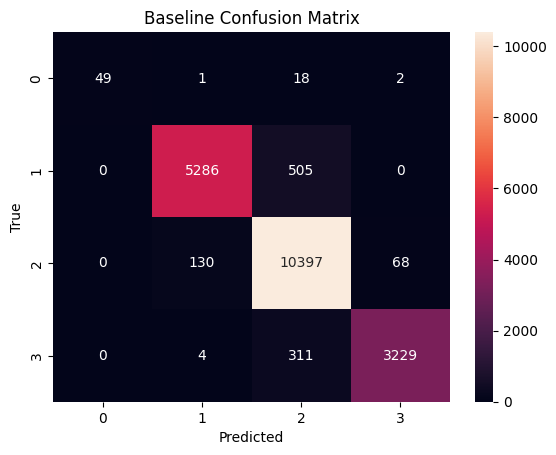

In [ ]:
y_pred_base = baseline_pipe.predict(X_test)

print("=== BASELINE PERFORMANCE ===")
print(classification_report(y_test, y_pred_base))

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Baseline Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 3- Identify Biased Feature

Check if predictions differ across the sensitive feature **City**.


Predicted distribution by City:


col_0,0,1,2,3
City,,,,
BadShire,0.000000,1.000000,0.000000,0.000000
Lonton,0.000000,0.001250,0.000000,0.998750
Standhampton,0.000000,0.012359,0.981306,0.006335
ZeroVille,0.803279,0.016393,0.147541,0.032787


C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Almi\AppDa

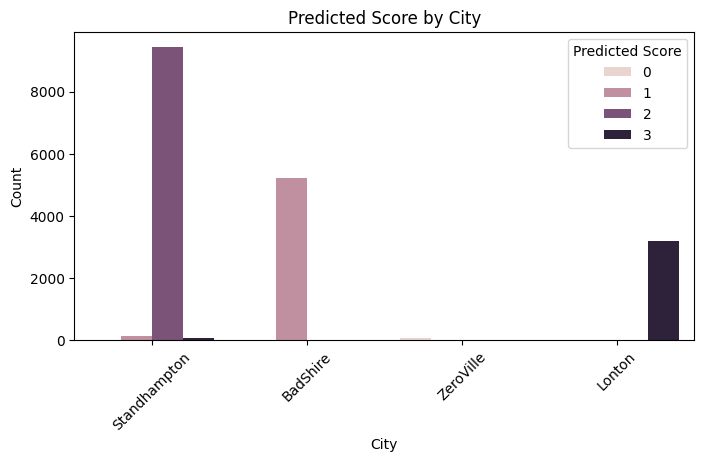

In [ ]:
print("Predicted distribution by City:")
display(pd.crosstab(X_test["City"], y_pred_base, normalize="index"))

# Visualize with countplot
plt.figure(figsize=(8,4))
sns.countplot(x="City", hue=y_pred_base, data=X_test.assign(pred=y_pred_base))
plt.title("Predicted Score by City")
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Count")
plt.legend(title="Predicted Score")
plt.show()


## 4- Mitigation: Drop “City”

We’ll remove **City** from features, rebuild & re-train.


In [ ]:
X_train_nb = X_train.drop("City", axis=1)
X_test_nb  = X_test.drop("City", axis=1)

# Recompute feature lists without City
num_feats_nb = get_numerical_features(X_train_nb)
cat_feats_nb = get_categorical_features(X_train_nb)

# Rebuild imputation + transformation pipelines
num_pipeline_nb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])
cat_pipeline_nb = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_nb = ColumnTransformer([
    ("num", num_pipeline_nb, num_feats_nb),
    ("cat", cat_pipeline_nb, cat_feats_nb),
])

# Assemble mitigated pipeline
mitigated_pipe = Pipeline([
    ("preproc", preprocessor_nb),
    ("clf",     RandomForestClassifier(random_state=42, n_estimators=100)),
])

# Fit mitigated pipeline
mitigated_pipe.fit(X_train_nb, y_train)
print("Mitigated pipeline (no City) trained.")


Mitigated pipeline (no City) trained.


## 5- Post-Mitigation Evaluation

Compare performance & fairness “before vs after”.


=== BASELINE PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        70
           1       0.98      0.91      0.94      5791
           2       0.93      0.98      0.95     10595
           3       0.98      0.91      0.94      3544

    accuracy                           0.95     20000
   macro avg       0.97      0.88      0.92     20000
weighted avg       0.95      0.95      0.95     20000

MAE: 0.05325
=== AFTER DROPPING CITY ===
              precision    recall  f1-score   support

           0       0.90      0.13      0.23        70
           1       0.80      0.81      0.80      5791
           2       0.80      0.83      0.81     10595
           3       0.79      0.71      0.74      3544

    accuracy                           0.80     20000
   macro avg       0.82      0.62      0.65     20000
weighted avg       0.80      0.80      0.80     20000

MAE: 0.20615


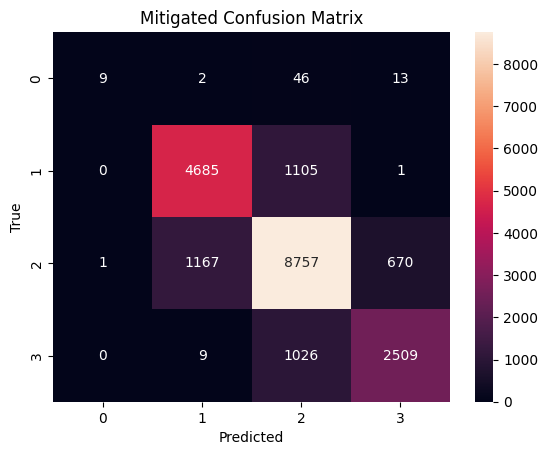

In [ ]:
# Cell 11: Predictions after mitigation
y_pred_nb = mitigated_pipe.predict(X_test_nb)

print("=== BASELINE PERFORMANCE ===")
print(classification_report(y_test, y_pred_base))
print("MAE:",mean_absolute_error(y_test, y_pred_base))
print("=== AFTER DROPPING CITY ===")
print(classification_report(y_test, y_pred_nb))
print("MAE:",mean_absolute_error(y_test, y_pred_nb))

# Visualize confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d")
plt.title("Mitigated Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 6- Summary Comparison

Tabulate & plot accuracy before vs after mitigation.


,Metric,Baseline,No_City
0,Accuracy,0.9480,0.7980
1,F1_macro,0.9157,0.6468
2,MAE,0.0532,0.2062


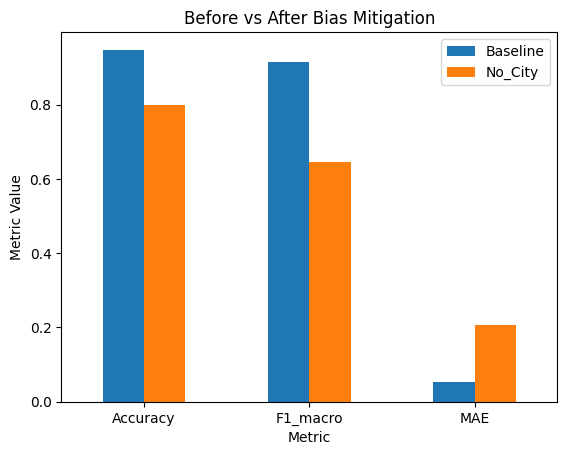

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# baseline
acc_base = accuracy_score(y_test, y_pred_base)
f1_base  = f1_score     (y_test, y_pred_base, average='macro')
mae_base = mean_absolute_error(y_test,y_pred_base)

# no-city
acc_nb   = accuracy_score(y_test, y_pred_nb)
f1_nb    = f1_score     (y_test, y_pred_nb, average='macro')
mae_nb = mean_absolute_error(y_test,y_pred_nb)

metrics_summary = pd.DataFrame({
    "Metric":    ["Accuracy", "F1_macro", "MAE"],
    "Baseline":  [np.round(acc_base, 4), np.round(f1_base, 4), np.round(mae_base,4)],
    "No_City":   [np.round(acc_nb,   4), np.round(f1_nb,   4), np.round(mae_nb,4)]
})
display(metrics_summary)

ax = metrics_summary.set_index("Metric")[["Baseline","No_City"]].plot.bar(rot=0)
ax.set_title("Before vs After Bias Mitigation")
ax.set_ylabel("Metric Value")
plt.show()

## Explainability

In [ ]:
import shap
import time
from joblib import Parallel, delayed

def fast_tree_shap_analysis(model_pipe, X, sample_size=50, random_state=42, n_jobs=-1):
    """
    Ultra-fast SHAP analysis optimized specifically for tree-based models
    
    Parameters:
    -----------
    model_pipe : sklearn Pipeline
        Fitted pipeline with preprocessing and a tree-based classifier
        
    X : pandas DataFrame
        Data to analyze
        
    sample_size : int, default=50
        Number of samples to use (reduce this for faster computation)
        
    random_state : int, default=42
        Random seed for reproducibility
        
    n_jobs : int, default=-1
        Number of jobs for parallel processing (-1 uses all cores)
        
    Returns:
    --------
    dict with explainer, shap_values, and feature info
    """
    start_time = time.time()
    
    # Sample the data - use a small sample size for speed
    X_sample = X.sample(n=sample_size, random_state=random_state) 
    print(f"Using {X_sample.shape[0]} samples for SHAP analysis")
    
    # Get the preprocessor and model from the pipeline
    preprocessor = model_pipe.named_steps['preproc']
    model = model_pipe.named_steps['clf']
    
    # Set model to use parallel computation if supported
    original_n_jobs = None
    if hasattr(model, 'n_jobs'):
        original_n_jobs = model.n_jobs
        model.n_jobs = n_jobs
        print(f"Set model to use {n_jobs} cores for parallel computation")
    
    # Transform the features
    print("Transforming features...")
    X_transformed = preprocessor.transform(X_sample)
    
    # Handle sparse output
    if hasattr(X_transformed, 'toarray'):
        X_transformed = X_transformed.toarray()
    
    # Try to get feature names (simplified approach for tree models)
    try:
        if hasattr(preprocessor, 'get_feature_names_out'):
            feature_names = preprocessor.get_feature_names_out()
        else:
            # Generic feature names - this is fine for tree models
            feature_names = [f"Feature_{i}" for i in range(X_transformed.shape[1])]
    except:
        feature_names = [f"Feature_{i}" for i in range(X_transformed.shape[1])]
    
    X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
    
    # Create SHAP TreeExplainer with optimizations for tree models
    print("Creating optimized TreeExplainer...")

    # Optimization for tree models with many features
    use_fast_mode = X_transformed_df.shape[1] > 50  # If more than 50 features
    
    try:
        if use_fast_mode:
            print("Using optimization for many features...")
            # TreeExplainer with interventional feature perturbation is faster with many features
            explainer = shap.TreeExplainer(
                model, 
                feature_perturbation="interventional",
                model_output="raw"
            )
        else:
            explainer = shap.TreeExplainer(model)
        
        # Calculate SHAP values (this is already very efficient for trees)
        print("Calculating SHAP values...")
        shap_values = explainer.shap_values(X_transformed_df)
        
        # Restore original n_jobs setting
        if hasattr(model, 'n_jobs') and original_n_jobs is not None:
            model.n_jobs = original_n_jobs
            
    except Exception as e:
        print(f"Error with TreeExplainer: {e}")
        
        # Try with less optimized approach
        print("Trying alternative TreeExplainer approach...")
        explainer = shap.TreeExplainer(model, data=X_transformed_df, check_additivity=False)
        shap_values = explainer.shap_values(X_transformed_df)
        
        # Restore original n_jobs
        if hasattr(model, 'n_jobs') and original_n_jobs is not None:
            model.n_jobs = original_n_jobs
    
    elapsed_time = time.time() - start_time
    print(f"SHAP analysis completed in {elapsed_time:.2f} seconds")
    
    return {
        'explainer': explainer,
        'shap_values': shap_values,
        'X_transformed': X_transformed_df,
        'feature_names': feature_names,
        'original_X': X_sample,
        'elapsed_time': elapsed_time
    }

def plot_tree_shap_results(shap_results, max_display=10, class_idx=None):
    """
    Generate optimized SHAP plots for tree-based models
    
    Parameters:
    -----------
    shap_results : dict
        Dictionary returned by fast_tree_shap_analysis
        
    max_display : int, default=10
        Maximum number of features to display
        
    class_idx : int, optional
        For multiclass problems, which class to analyze
    """
    if shap_results is None:
        print("No SHAP results to plot.")
        return
    
    shap_values = shap_results['shap_values']
    X_transformed = shap_results['X_transformed']
    feature_names = shap_results['feature_names']
    
    # Determine if this is a multiclass problem
    is_multiclass = isinstance(shap_values, list) and len(shap_values) > 1
    
    # If multiclass, allow selecting a class to analyze
    if is_multiclass and class_idx is not None:
        if class_idx < len(shap_values):
            values_to_plot = shap_values[class_idx]
            class_label = f"Class {class_idx}"
        else:
            values_to_plot = shap_values[0]
            class_label = "Class 0 (default)"
    elif is_multiclass:
        values_to_plot = shap_values[0]
        class_label = "Class 0 (default)"
    else:
        values_to_plot = shap_values
        class_label = ""
    
    # Summary Plot - focused on top features
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        values_to_plot, 
        X_transformed, 
        feature_names=feature_names, 
        max_display=max_display,
        show=False
    )
    
    if is_multiclass:
        plt.title(f"SHAP Summary Plot - {class_label}")
    else:
        plt.title("SHAP Summary Plot - Top Features")
        
    plt.tight_layout()
    plt.show()
    
    # Bar Plot for feature importance
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        values_to_plot, 
        X_transformed, 
        feature_names=feature_names,
        plot_type="bar", 
        max_display=max_display,
        show=False
    )
    
    if is_multiclass:
        plt.title(f"SHAP Feature Importance - {class_label}")
    else:
        plt.title("SHAP Feature Importance - Top Features")
        
    plt.tight_layout()
    plt.show()
    
    # Get the top features
    if not isinstance(values_to_plot, list):
        importance = np.abs(values_to_plot).mean(0)
        top_idx = importance.argsort()[-3:][::-1]  # Top 3 features, highest first
        
        # Create dependence plots only for the most important features
        for i, idx in enumerate(top_idx):
            if i >= 2:  # Only show top 2 for speed
                break
                
            if idx < len(feature_names):
                feature = feature_names[idx]
                plt.figure(figsize=(10, 6))
                shap.dependence_plot(
                    idx, 
                    values_to_plot, 
                    X_transformed,
                    feature_names=feature_names,
                    show=False
                )
                plt.title(f"SHAP Dependence Plot - {feature}")
                plt.tight_layout()
                plt.show()
    
    # Interactive dashboard with force plots (when in notebook)
    try:
        # Try to create a force plot for a few samples
        if is_multiclass:
            base_value = shap_results['explainer'].expected_value[0] if isinstance(shap_results['explainer'].expected_value, list) else shap_results['explainer'].expected_value
            sample_to_plot = values_to_plot[0]
        else:
            base_value = shap_results['explainer'].expected_value
            sample_to_plot = values_to_plot[0]
        
        # Create a small force plot
        print("Sample explanation for a single prediction:")
        display(shap.force_plot(base_value, sample_to_plot, X_transformed.iloc[0], feature_names=feature_names, matplotlib=True))
    except Exception as e:
        print(f"Note: Interactive force plot couldn't be displayed: {e}")
    
    return

# Function to find optimal sample size based on convergence
def find_optimal_sample_size(model_pipe, X, max_time_seconds=60, random_state=42):
    """
    Find optimal sample size that provides stable SHAP values within time constraints
    
    Parameters:
    -----------
    model_pipe : sklearn Pipeline
        Fitted pipeline with tree-based model
    
    X : pandas DataFrame
        Data to analyze
        
    max_time_seconds : int, default=60
        Maximum time budget in seconds
        
    Returns:
    --------
    optimal_sample_size : int
        Recommended sample size
    """
    # Try increasing sample sizes to find optimal balance
    sample_sizes = [25, 50, 100, 200, 400]
    times = []
    values = []
    
    for size in sample_sizes:
        print(f"\nTesting with sample size {size}...")
        start = time.time()
        
        try:
            results = fast_tree_shap_analysis(model_pipe, X, sample_size=size, random_state=random_state)
            elapsed = time.time() - start
            
            # If we have multiclass, just look at first class
            if isinstance(results['shap_values'], list):
                values.append(np.abs(results['shap_values'][0]).mean(0))
            else:
                values.append(np.abs(results['shap_values']).mean(0))
                
            times.append(elapsed)
            
            print(f"Sample size {size} completed in {elapsed:.2f} seconds")
            
            # Stop if we exceed the time budget
            if elapsed > max_time_seconds:
                print(f"Exceeded time budget of {max_time_seconds} seconds")
                break
                
        except Exception as e:
            print(f"Error with sample size {size}: {e}")
            break
    
    # Find when values stabilize
    if len(values) < 2:
        return 25  # Default to minimum if we only have one sample size
    
    # Compare feature importance rankings between consecutive sample sizes
    stabilized_idx = None
    for i in range(1, len(values)):
        # Get top feature indices for both sample sizes
        prev_top = values[i-1].argsort()[-10:]
        curr_top = values[i].argsort()[-10:]
        
        # Calculate overlap in top 10 features
        overlap = len(set(prev_top) & set(curr_top))
        overlap_ratio = overlap / 10.0
        
        print(f"Overlap ratio between {sample_sizes[i-1]} and {sample_sizes[i]} samples: {overlap_ratio:.2f}")
        
        # Consider stable if 80% of top features are the same
        if overlap_ratio >= 0.8:
            stabilized_idx = i-1
            break
    
    # Choose based on stability and time
    if stabilized_idx is not None:
        optimal_size = sample_sizes[stabilized_idx]
        print(f"Found optimal sample size {optimal_size} (stable results)")
    else:
        # If no stability found, choose largest size within time budget
        for i, t in enumerate(times):
            if t > max_time_seconds * 0.8:  # 80% of max time
                optimal_size = sample_sizes[max(0, i-1)]
                break
        else:
            optimal_size = sample_sizes[-1]
            
        print(f"Using sample size {optimal_size} (based on time constraint)")
    
    return optimal_size

# Example usage
# Find optimal sample size first (within 60 seconds)
# optimal_size = find_optimal_sample_size(model_pipe, X_test, max_time_seconds=60)

# Then run with that size
# shap_results = fast_tree_shap_analysis(model_pipe, X_test, sample_size=optimal_size)
# plot_tree_shap_results(shap_results)

# Or just use default settings with small sample
#shap_results = fast_tree_shap_analysis(mitigated_pipe, X_test, sample_size=50)
#plot_tree_shap_results(shap_results)

# Find the optimal sample size based on stability and time constraints
optimal_size = find_optimal_sample_size(mitigated_pipe, X_test, max_time_seconds=60)

# Then run with the optimal size
shap_results = fast_tree_shap_analysis(mitigated_pipe, X_test, sample_size=optimal_size)
plot_tree_shap_results(shap_results)

C:\Users\Almi\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'mitigated_pipe' is not defined